In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

from evaluation import get_cm_sklearn, print_metrics
from preprocessing import TrainingPreProcessor

RANDOM_STATE = 0

train_set = pd.read_csv("input/train.csv")
train_set.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,713071383,Existing Customer,54,F,1,Unknown,Single,Unknown,Blue,36,...,3,3,3723.0,1728,1995.0,0.595,8554,99,0.678,0.464
1,714246333,Attrited Customer,58,F,4,High School,Married,Unknown,Blue,48,...,4,3,5396.0,1803,3593.0,0.493,2107,39,0.393,0.334
2,718206783,Existing Customer,45,F,4,Unknown,Single,Less than $40K,Gold,36,...,1,3,15987.0,1648,14339.0,0.732,1436,36,1.250,0.103
3,721096983,Existing Customer,34,F,2,Graduate,Single,Less than $40K,Blue,36,...,3,4,3625.0,2517,1108.0,1.158,2616,46,1.300,0.694
4,720028683,Existing Customer,49,F,2,High School,Married,$40K - $60K,Blue,39,...,3,4,2720.0,1926,794.0,0.602,3806,61,0.794,0.708


In [2]:
training_preprocessor = TrainingPreProcessor()
training_preprocessor.fit(train_set, ignore_columns=["CLIENTNUM"])
class_weight = training_preprocessor.class_weight
class_weight, training_preprocessor.label_encoder.classes_

({0: 3.1157692307692306, 1: 0.5955741802676077},
 array(['Attrited Customer', 'Existing Customer'], dtype=object))

In [3]:
X, y = training_preprocessor.transform(train_set)
X.shape, y.shape

((8101, 37), (8101,))

In [4]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, shuffle=True
)

## Regressão logística

In [5]:
logistic_regression_model = LogisticRegression(
    random_state=RANDOM_STATE, class_weight=class_weight, max_iter=1000
)
logistic_regression_model.fit(X_train, y_train)

LogisticRegression(class_weight={0: 3.1157692307692306, 1: 0.5955741802676077},
                   max_iter=1000, random_state=0)

### Avaliação do modelo regressão logística

Accuracy: 0.8519432449105491
Balanced Accuracy: 0.8365736888334142
F1: 0.9073359073359073
RoC AuC: 0.8365736888334142


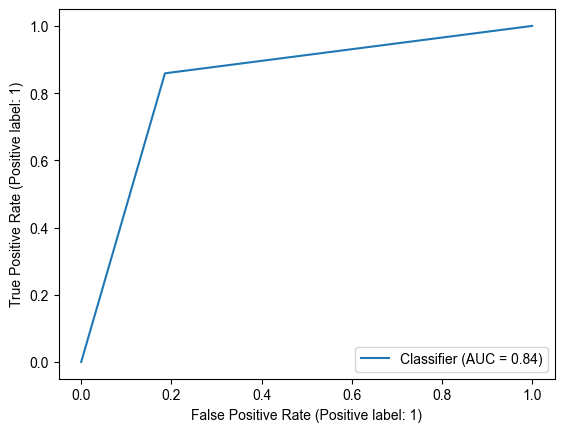

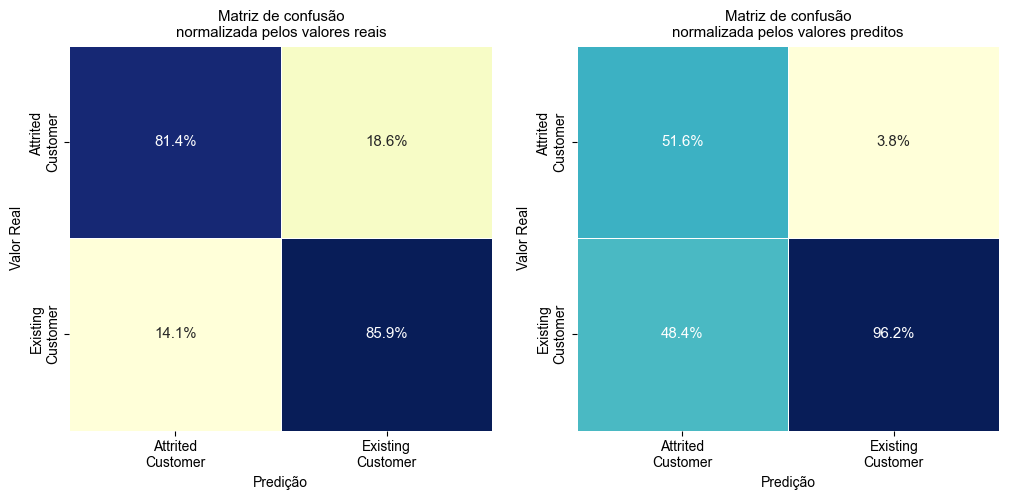

In [6]:
y_pred_val_logistic = logistic_regression_model.predict(X_val)

print_metrics(y_val, y_pred_val_logistic)

get_cm_sklearn(
    y_val,
    y_pred_val_logistic,
    labels=[
        "\n".join(label.split())
        for label in training_preprocessor.label_encoder.classes_
    ],
)

## SVC

In [7]:
svc_model = SVC(random_state=RANDOM_STATE, class_weight=class_weight)
svc_model.fit(X_train, y_train)

SVC(class_weight={0: 3.1157692307692306, 1: 0.5955741802676077}, random_state=0)

### Avaliação do modelo SVC

Accuracy: 0.9136335595311537
Balanced Accuracy: 0.9037283591059335
F1: 0.947209653092006
RoC AuC: 0.9037283591059334


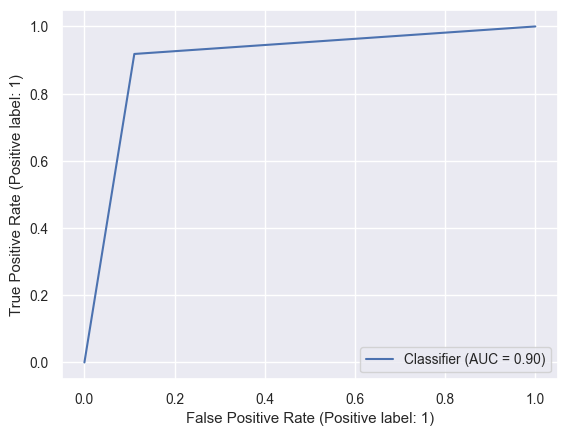

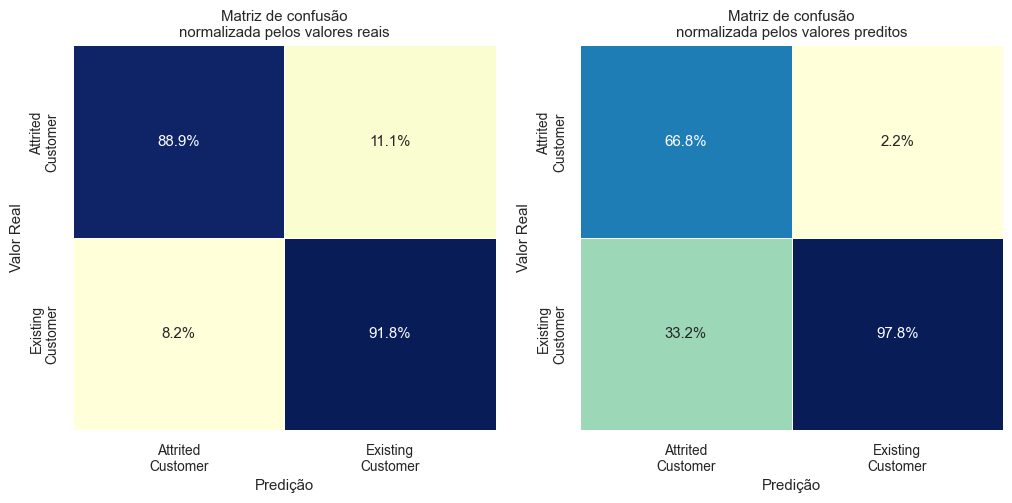

In [8]:
y_pred_val_svc = svc_model.predict(X_val)

print_metrics(y_val, y_pred_val_svc)

get_cm_sklearn(
    y_val,
    y_pred_val_svc,
    labels=[
        "\n".join(label.split())
        for label in training_preprocessor.label_encoder.classes_
    ],
)

## Floresta aleatória

In [9]:
rf_model = RandomForestClassifier(random_state=RANDOM_STATE, class_weight=class_weight)
rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight={0: 3.1157692307692306,
                                     1: 0.5955741802676077},
                       random_state=0)

### Avaliação do modelo floresta aleatória

Accuracy: 0.9450956199876619
Balanced Accuracy: 0.8531048470979821
F1: 0.968088920760129
RoC AuC: 0.8531048470979823


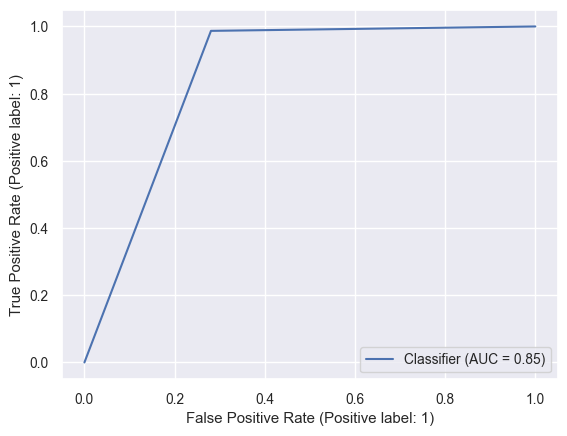

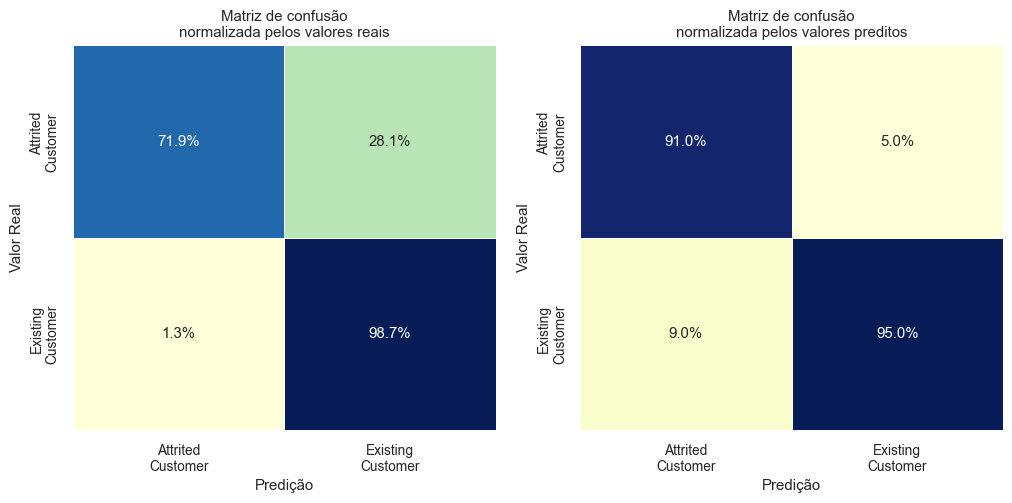

In [10]:
y_pred_val_rf = rf_model.predict(X_val)

print_metrics(y_val, y_pred_val_rf)

get_cm_sklearn(
    y_val,
    y_pred_val_rf,
    labels=[
        "\n".join(label.split())
        for label in training_preprocessor.label_encoder.classes_
    ],
)